Enter your Longitude, Latitude coordinates in 
                            DMS ex:3°13"28.918"E, 51°12'33.653"N or 
                            WSG84 ex : 3.2246995, 51.209348 or
                            Lambert72 ex : 70053.52, 211658.26 : 3°13"28.918"E, 51°12'33.653"N


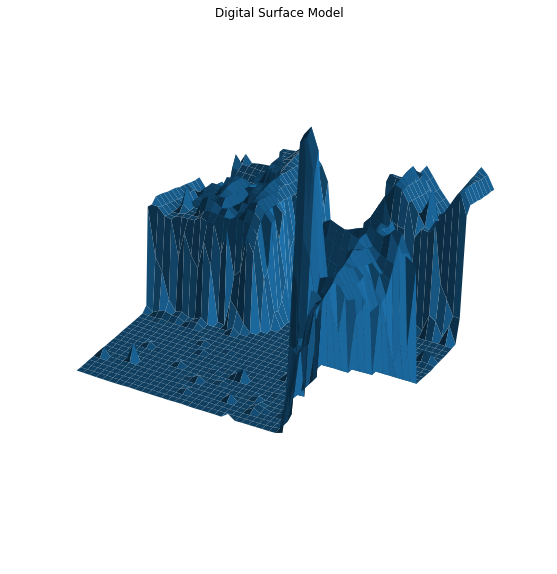

In [1]:
#This program ask for coordinates of Brugge downtown and return a 3D plot of the LIDAR DSM map

import matplotlib.pyplot as plt
import numpy as np
import rasterio as rs
from rasterio.mask import mask
from shapely.geometry import Polygon
import pyproj
import re


def main():

    #asking for input
    x = input("""Enter your Longitude, Latitude coordinates in 
                            DMS ex:3°13"28.918"E, 51°12'33.653"N or 
                            WSG84 ex : 3.2246995, 51.209348 or
                            Lambert72 ex : 70053.52, 211658.26 : """)

    #function that transform DMS coordinates to DD WSG84 coordinates
    def dms2dd():
        #Extraction of longitude / latitude
        LAT, LON = map(str, x.split(''','''))

        #extraction of figure with regex
        degreesLON, minutesLON, secondsLON, directionLON = re.split('[°\'"]+', LON)
        #Transfomation formula
        ddLON = float(degreesLON) + float(minutesLON) / 60 + float(secondsLON) / (60 * 60);
        #Negative transformation for west values
        if directionLON in ('W'):
            ddLON *= -1

        # extraction of figure with regex
        degreesLAT, minutesLAT, secondsLAT, directionLAT = re.split('[°\'"]+', LAT)
        # Transfomation formula
        ddLAT = float(degreesLAT) + float(minutesLAT) / 60 + float(secondsLAT) / (60 * 60);
        # Negative transformation for south values
        if directionLAT in ('S'):
            ddLAT *= -1
        #return of the result
        return (ddLON, ddLAT)

    #If there is E in the input, apply the function
    if 'E' in x:
        y1, x1 = dms2dd()
    #Else separate the float values
    else:
        x1, y1 = map(float, x.split(''','''))

    #If the float are below 180° we are in WGS84 otherwise in Lambert72
    if x1 < 180 and y1 < 180:
        proj = pyproj.Transformer.from_crs(4326, 31370)
        x1, y1 = proj.transform(y1, x1)

    #definition of the length of the mask
    edgelen = 40

    # creation of the region of interest (roi) with polygon, a square
    roi = Polygon([(x1 - int(edgelen / 2), y1 + int(edgelen / 2)),
                   (x1 + int(edgelen / 2), y1 + int(edgelen / 2)),
                   (x1 + int(edgelen / 2), y1 - int(edgelen / 2)),
                   (x1 - int(edgelen / 2), y1 - int(edgelen / 2))])

    # Opening of the file
    fp = r'C:\Users\emora\OneDrive\Documents\GitHub\final_challenge_EM\DHMVIIDSMRAS1m_k13.tif'
    with rs.open(fp) as src:
        # Masking of the image
        out_image, out_transform = rs.mask.mask(src, shapes=[roi], crop=True, filled=False)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        # getting rid of the NAN value and change to numerical value
        diff_surf = np.nan_to_num(out_image)

        # Defining of x and y
        temp_x = np.arange(diff_surf.shape[2])
        temp_y = np.arange(diff_surf.shape[1])

        # Fliping of y value
        temp_y = np.flip(temp_y, 0)

        # Creation of the meshgrid
        X_diff, Y_diff = np.meshgrid(temp_x, temp_y)

        # Definition of Z layer
        Z_diff = diff_surf[0]

        # Plot DSM in Python
        fig_dsm = plt.figure(figsize=(10, 10))

        # definition of the subplot
        ax = fig_dsm.add_subplot(111, projection='3d')
        # axis off
        ax.axis('off')

        # Plot
        ax.plot_surface(X_diff, Y_diff, Z_diff, rstride=1, cstride=1, linewidth=5)

        # limit of the Z height and plot of title
        ax.set_zlim3d(0, 30)
        plt.title("Digital Surface Model")

        # show the plot
        plt.show()

if __name__ == "__main__":
    main()


# Test bruges
# DMS (LAT , LON) 3°13'28.918"E, 51°12'33.653"N
# DD 3.2246995, 51.209348
# Lambert72 ; 70053.52, 211658.26